In [327]:
library(devtools)
library(ggridges)
library(dplyr)
library(tidyr)
library(ggplot2)
library(quantmod)
library(xts)
library(zoo)
library(gridExtra)
library(tidyverse)
library(tibble)
library(grid)
library(DescTools)

set.seed(1)
load_all("../vendor/hmmTMB")
source("markets_functions.R")  # adjust path if the notebook’s cwd differs

ℹ Loading hmmTMB


Warning message:
“CL=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“GC=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“HG=F contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Dropping columns with NA fraction > 0.15: Canada_Utilities_Index, Canada_Consumer_Staples_Index, Canada_Health_Care_Index

Warning message:
“Setting row names on a tibble is deprecated.”


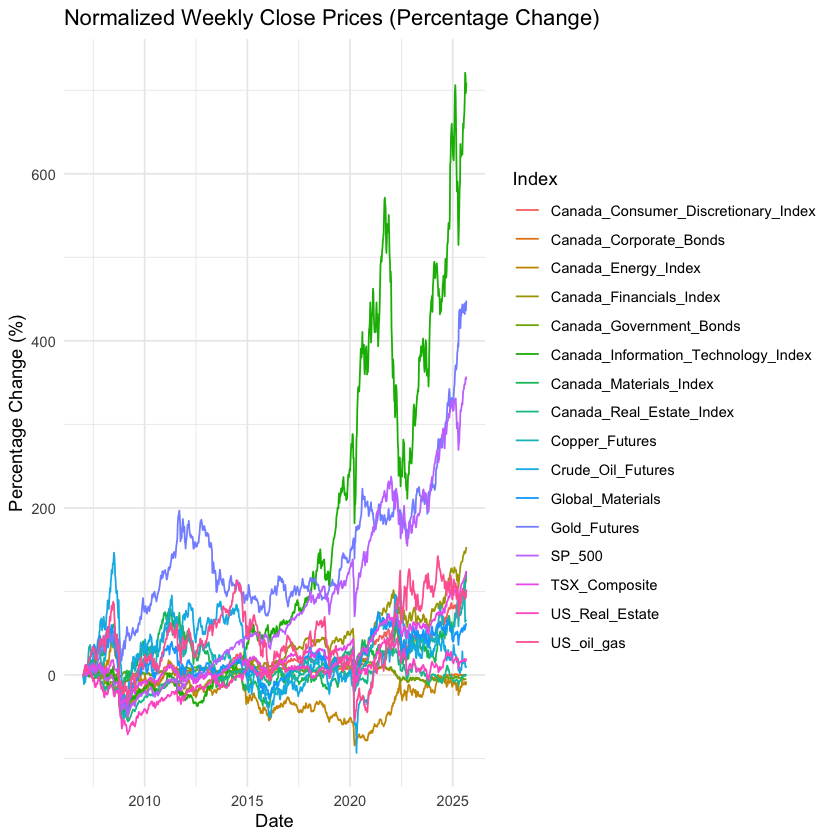

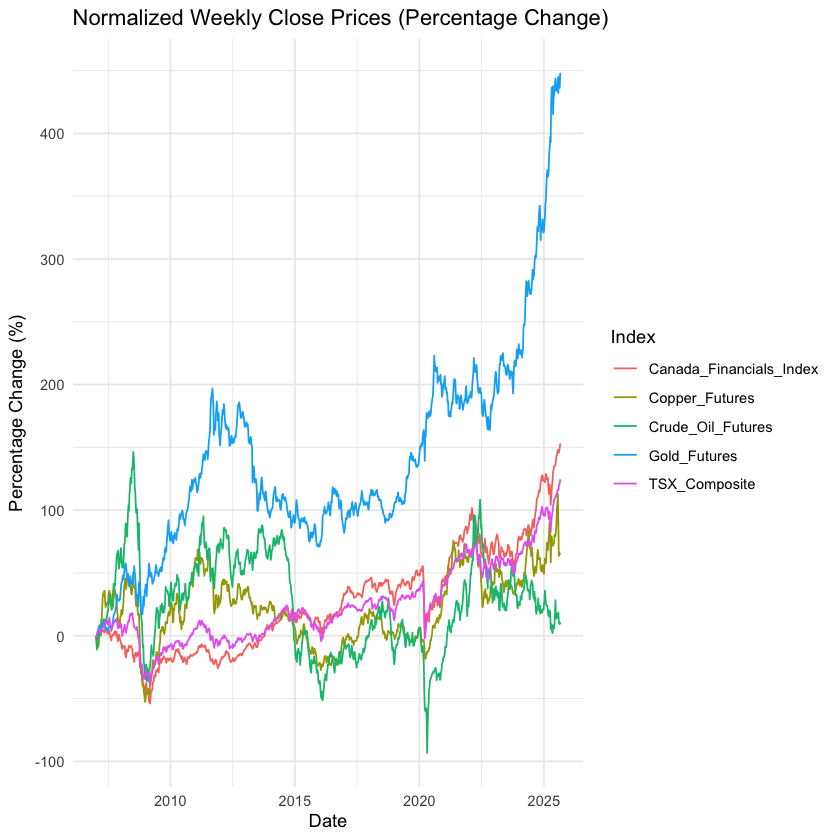

In [ ]:
close_data <- get_markets_data("2007-01-01", "2025-09-01", "weeks", plot=TRUE)

close_data <- close_data %>%
  select(Date, 
    TSX_Composite, Canada_Financials_Index,
    Crude_Oil_Futures, Gold_Futures, Copper_Futures
  )

close_data_log <- ln_transform(close_data)

# Reshape data for ggplot
close_data_long <- close_data %>%
  pivot_longer(-Date, names_to = "Index", values_to = "Close") %>%
  group_by(Index) %>%
  mutate(Close = (Close / first(Close) - 1) * 100)

# Plot using ggplot2
ggplot(close_data_long, aes(x = Date, y = Close, color = Index)) +
  geom_line() +
  labs(title = "Normalized Weekly Close Prices (Percentage Change)", x = "Date", y = "Percentage Change (%)") +
  theme_minimal()


In [422]:
state_list <- list()  # Initialize an empty list to collect state vectors
par_list <- list()  # Initialize an empty list to collect parameters
recoded_states_list <- list()  # Initialize an empty list to collect recoded states
for (col in setdiff(colnames(close_data_log), "Date")) {  # Exclude 'Date' directly
  hmm_model <- fit_hmm(
    n_states = 3,
    data = close_data_log,
    obs_name = col,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = NULL
  )
  states <- hmm_model$states()  # Extract states as a vector
  state_list[[col]] <- states   # Add to list with column name as key

  obs_par <- matrix(hmm_model$obs()$par(), ncol = 2, byrow = TRUE)  # Extract observation parameters
  obs_par <- cbind(obs_par, matrix(table(states), ncol = 1))
  colnames(obs_par) <- c("mean", "sd", "count")

  high_var_state <- which.max(obs_par[, "sd"])
  growth_state <- which.max(obs_par[, "mean"])
  mid_state <- setdiff(1:3, c(high_var_state, growth_state))

  state_labels <- c("high_variance", "mid", "growth")[match(1:3, c(high_var_state, mid_state, growth_state))]
  obs_par <- cbind(obs_par, state_label = state_labels)

  # Recode states: -1 = high variance, 0 = mid, 1 = growth
  recoded_states <- sapply(states, function(s) {
    if (s == high_var_state) {
      return(-1)
    } else if (s == growth_state) {
      return(1)
    } else {
      return(0)
    }
  })
  recoded_states_list[[col]] <- recoded_states
  par_list[[col]] <- obs_par
}

# Combine the list into a data frame
state_df <- do.call(cbind.data.frame, state_list)
recoded_df <- do.call(cbind.data.frame, recoded_states_list)

# View the first few rows
head(state_df, 3)
head(recoded_df, 3)

,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures
,<int>,<int>,<int>,<int>,<int>
1,3,3,2,3,2
2,3,3,2,3,2
3,3,3,2,2,2


,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,0,1
2,1,1,0,0,1
3,1,1,0,1,1


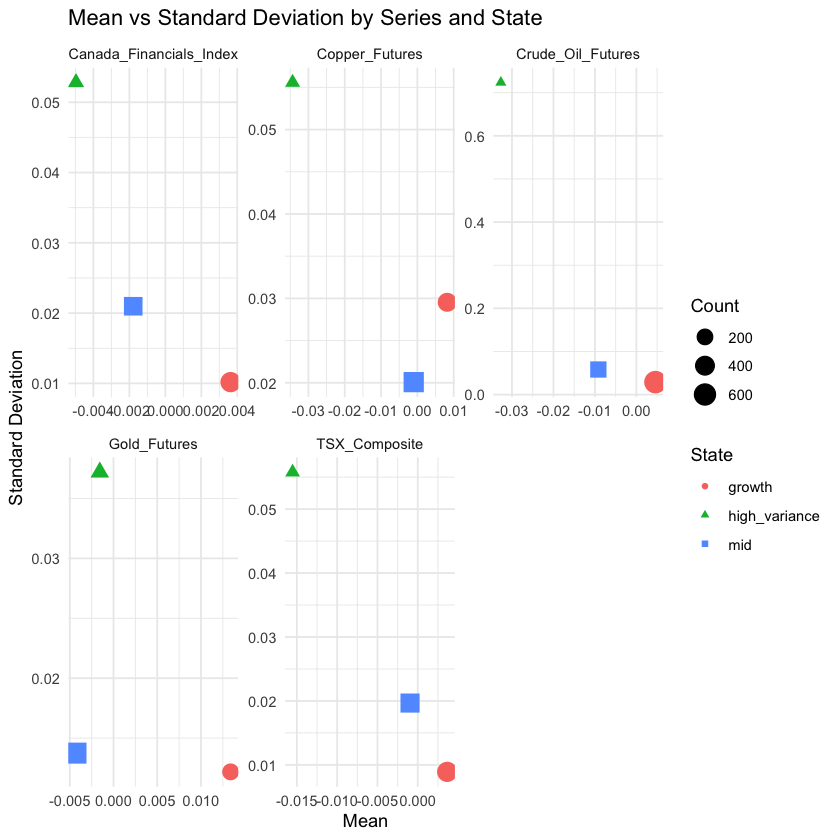

In [430]:
# Convert par_list to a data frame for plotting
par_df <- do.call(rbind, lapply(names(par_list), function(name) {
  data.frame(
    Series = name,
    State = par_list[[name]][, "state_label"],
    mean = as.numeric(par_list[[name]][, "mean"]),
    sd = as.numeric(par_list[[name]][, "sd"]),
    count = as.numeric(par_list[[name]][, "count"])
  )
}))

# Plot mean vs sd with facets for each series
ggplot(par_df, aes(x = mean, y = sd, size = count, color = factor(State), shape = factor(State))) +
  geom_point() +
  facet_wrap(~ Series, scales = "free") +
  labs(title = "Mean vs Standard Deviation by Series and State",
       x = "Mean",
       y = "Standard Deviation",
       color = "State",
       shape = "State",
       size = "Count") +
  scale_size_continuous(range = c(2, 6)) +
  theme_minimal()

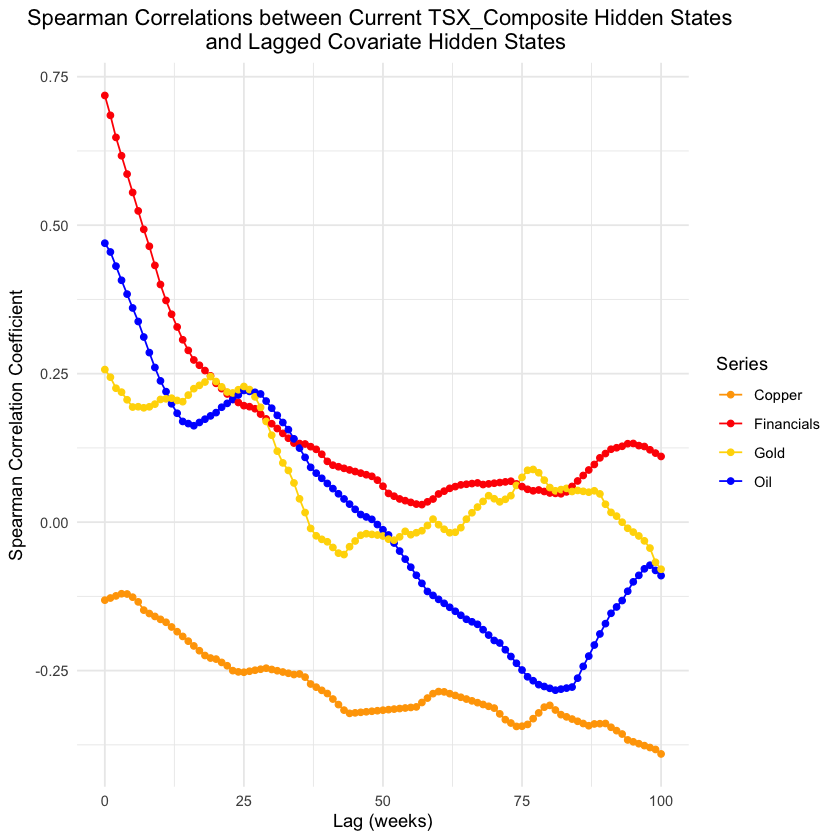

In [438]:
library(dplyr)
library(ggplot2)
library(tidyr)

# Extract the relevant series (assuming no leading/trailing NAs; filter if needed)
tsx <- recoded_df$TSX_Composite
fin <- recoded_df$Canada_Financials_Index
oil <- recoded_df$Crude_Oil_Futures
gold <- recoded_df$Gold_Futures
copper <- recoded_df$Copper_Futures

# Define the maximum lag (adjust as needed, e.g., 200 for approximately 4 years of weekly data)
max_lag <- 100

# Function to compute correlations for lags 0 to max_lag
compute_cor_lags <- function(series1, series2, max_lag, method = "spearman") {
  lags <- 0:max_lag
  corrs <- sapply(lags, function(lag) {
    if (lag == 0) {
      cor(series1, series2, method = method, use = "complete.obs")
    } else {
      series2_shifted <- lag(series2, n = lag)
      cor(series1, series2_shifted, method = method, use = "complete.obs")
    }
  })
  corrs
}

# Compute correlations for each series
lags <- 0:max_lag
plot_data <- data.frame(lag = lags)
plot_data$Financials <- compute_cor_lags(tsx, fin, max_lag)
plot_data$Oil <- compute_cor_lags(tsx, oil, max_lag)
plot_data$Gold <- compute_cor_lags(tsx, gold, max_lag)
plot_data$Copper <- compute_cor_lags(tsx, copper, max_lag)

# Convert to long format for plotting
plot_data_long <- plot_data %>%
  pivot_longer(cols = -lag, names_to = "Series", values_to = "correlation")

# Plot the results
ggplot(plot_data_long, aes(x = lag, y = correlation, color = Series)) +
  geom_line() +
  geom_point(size = 1.5) +
  scale_color_manual(values = c("Financials" = "red", "Oil" = "blue", "Gold" = "gold", "Copper" = "orange")) +
  labs(title = "Spearman Correlations between Current TSX_Composite Hidden States \n and Lagged Covariate Hidden States",
       x = "Lag (weeks)",
       y = "Spearman Correlation Coefficient") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [506]:
train_size <- 400
test_size <- 25
samples <- 5
splits <- train_test_split(
  close_data,
  training_period = train_size,
  testing_period = test_size,
  samples = samples
)
log_train <- lapply(splits$train, function(x) ln_transform(x))
log_test <- lapply(seq_along(splits$test), function(i) ln_transform(splits$test[[i]], previous_row = tail(splits$train[[i]], 1)))

train_data <- log_train[[1]]
test_data <- log_test[[1]]

head(train_data, 3)
head(test_data, 3)

,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000
2,-0.01164651,-0.011632406,-0.06601378,-0.01415782,-0.03803347
3,0.01427461,0.008381472,-0.05008433,0.02541448,-0.02542768


,TSX_Composite,Canada_Financials_Index,Crude_Oil_Futures,Gold_Futures,Copper_Futures
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0006463937,0.003156652,-0.00297304,-0.01382716,-0.009735184
2,-0.0051018352,0.002318788,-0.01720370,-0.01899228,-0.008495220
3,-0.0083975823,0.001593909,0.01187263,-0.01070067,0.001157230


In [495]:
plot_logloss <- function(loss_list, title) {
  # convert to matrix: rows = series, cols = time points
  mat <- do.call(rbind, loss_list)

  m     <- colMeans(mat)
  q90   <- apply(mat, 2, quantile, probs = c(0.05, 0.95), na.rm = TRUE)
  lower <- q90[1, ]
  upper <- q90[2, ]
  x <- seq_len(ncol(mat))

  plot(x, m, type = "n", ylim = range(c(lower, upper)),
      xlab = "t", ylab = "cross-entropy")

  apply(mat, 1, function(row) lines(x, row, col = adjustcolor("gray70", 0.6)))
  polygon(c(x, rev(x)), c(upper, rev(lower)),
          col = adjustcolor("black", 0.2), border = NA)
  lines(x, m, col = "black", lwd = 2)

  title(main = title)
}

In [508]:
source("markets_functions.R") 

obs_name <- "TSX_Composite"
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)

state_logloss <- list()
prediction_logloss <- list()
for (i in seq_len(samples)) {
  train_data <- log_train[[i]]
  test_data <- log_test[[i]]
  combined <- rbind(train_data, test_data)

  hmm <- fit_hmm(
    data = train_data,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
  )
  forecast <- Forecast$new(
    hmm = hmm,
    forecast_data = test_data,
    starting_state_distribution = "last",
    preset_eval_range = setNames(list(eval_range), obs_name)
  )
  true_model <- fit_hmm(
    data = combined,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~1"),
    horseshoe = FALSE,
    init = hmm
  )
  # Get State forecast log loss
  forecast_states <- matrix(forecast$hidden_state_forecast(), ncol = n_states, byrow = TRUE)
  true_states <- true_model$state_probs()[(1+nrow(train_data)):nrow(combined), ]

  state_cross_entropy <- -rowSums(true_states * log(forecast_states + 1e-10))
  state_logloss[[i]] <- state_cross_entropy

  # Get overall prediction log loss
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range <- forecast$eval_range()[[obs_name]]
  logloss <- list()
  for (j in seq_len(nrow(test_data))) {
    pdf_val <- approx(
      x = eval_range,
      y = forecast_dists[, j],
      xout = test_data[[obs_name]][j]
    )$y
    logloss[[j]] <- -log(pdf_val)
  }
  prediction_logloss[[i]] <- as.numeric(logloss)
}


Warning message in hmm$fit(silent = TRUE):
“Convergence code was not zero, indicating that the optimizer may not have converged to the correct estimates. Please check by consulting the out() function which shows what nlminb returned.”


In [509]:
source("markets_functions.R") 

obs_name <- "TSX_Composite"
cov_name <- "Crude_Oil_Futures"
n_states <- 3
eval_range <- seq(from = -0.2, to = 0.2, by = 0.001)

cov_state_logloss <- list()
cov_prediction_logloss <- list()
for (i in seq_len(samples)) {
  train_data <- log_train[[i]]
  test_data <- log_test[[i]]
  covariate <- fit_hmm(
      data = train_data,
      obs_name = cov_name,
      n_states = n_states,
      hid_formula = as.formula("~1"),
      horseshoe = FALSE,
    )
  cov_states <- covariate$state_probs()
  colnames(cov_states) <- paste0(cov_name, "_State_", 1:n_states)

  obs_train <- lead(train_data[obs_name], n = test_size)

  cov_data <- cbind(obs_train, cov_states)
  cov_train <- cov_data[1:(train_size - test_size), ]
  cov_test <- cov_data[(train_size - test_size + 1):train_size, ]

  hmm <- fit_hmm(
    data = cov_train,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~Gold_State_1 + Gold_State_2 + Gold_State_3"),
    horseshoe = FALSE,
  )
  forecast <- Forecast$new(
    hmm = hmm,
    forecast_data = cov_test,
    starting_state_distribution = "last",
    preset_eval_range = setNames(list(eval_range), obs_name)
  )

  cov_test[[obs_name]] <- test_data[[obs_name]]
  combined_data <- rbind(cov_train, cov_test)

  true_model <- fit_hmm(
    data = combined_data,
    obs_name = obs_name,
    n_states = n_states,
    hid_formula = as.formula("~Gold_State_1 + Gold_State_2 + Gold_State_3"),
    horseshoe = FALSE,
    init = hmm
  )

  forecast_states <- matrix(forecast$hidden_state_forecast(), ncol = n_states, byrow = TRUE)
  true_states <- true_model$state_probs()[(1+train_size - test_size):train_size, ]

  state_cross_entropy <- -rowSums(true_states * log(forecast_states + 1e-10))
  cov_state_logloss[[i]] <- state_cross_entropy

  # Get overall prediction log loss
  forecast_dists <- forecast$forecast_dists()[[obs_name]]
  eval_range <- forecast$eval_range()[[obs_name]]
  logloss <- list()
  for (j in seq_len(nrow(test_data))) {
    pdf_val <- approx(
      x = eval_range,
      y = forecast_dists[, j],
      xout = test_data[[obs_name]][j]
    )$y
    logloss[[j]] <- -log(pdf_val)
  }

  cov_prediction_logloss[[i]] <- as.numeric(logloss)
}
plot_logloss(cov_state_logloss, "Covariate State Prediction Log-Loss")
plot_logloss(state_logloss, "State Prediction Log-Loss")
plot_logloss(cov_prediction_logloss, "Covariate Observation Prediction Log-Loss")
plot_logloss(prediction_logloss, "Observation Prediction Log-Loss")

ERROR: Error in `[.data.frame`(data, , var_names, drop = FALSE): undefined columns selected


In [503]:
plot_logloss <- function(..., title) {
  # Capture the call to extract argument names
  call <- match.call(expand.dots = FALSE)
  arg_names <- names(call$...)  # Get names of the ... arguments
  loss_lists <- list(...)
  n_groups <- length(loss_lists)
  if (n_groups < 1) stop("At least one loss_list is required.")

  # Compute statistics for each group
  stats <- lapply(loss_lists, function(loss_list) {
    mat <- do.call(rbind, loss_list)
    m <- colMeans(mat, na.rm = TRUE)
    q90 <- apply(mat, 2, quantile, probs = c(0.05, 0.95), na.rm = TRUE)
    list(mat = mat, m = m, lower = q90[1, ], upper = q90[2, ])
  })

  # Assume all groups have the same number of time points
  t_max <- length(stats[[1]]$m)
  if (!all(sapply(stats, function(s) length(s$m) == t_max))) {
    stop("All loss_lists must have the same number of time points.")
  }

  # Determine overall y-range
  all_bounds <- unlist(lapply(stats, function(s) c(s$lower, s$upper)))
  ylim <- range(all_bounds, na.rm = TRUE)

  # Time points
  x <- seq_len(t_max)

  # Set up empty plot
  plot(x, type = "n", ylim = ylim, xlab = "t", ylab = "cross-entropy")
  title(main = title)

  # Define colors (using rainbow for automatic differentiation; adjust as needed)
  colors <- rainbow(n_groups)

  # Group names: use provided argument names if available, else "Group x"
  group_names <- ifelse(is.null(arg_names) | arg_names == "", 
                        paste("Group", seq_len(n_groups)), 
                        arg_names)

  # Plot each group
  for (i in seq_len(n_groups)) {
    s <- stats[[i]]
    col <- colors[i]

    # Individual series lines only if single group
    if (n_groups == 1) {
      apply(s$mat, 1, function(row) lines(x, row, col = adjustcolor(col, 0.6)))
    }

    # Confidence band
    polygon(c(x, rev(x)), c(s$upper, rev(s$lower)),
            col = adjustcolor(col, 0.2), border = NA)

    # Mean line
    lines(x, s$m, col = col, lwd = 2)
  }

  # Add legend
  legend("topright", legend = group_names, fill = colors, title = "Groups")
}

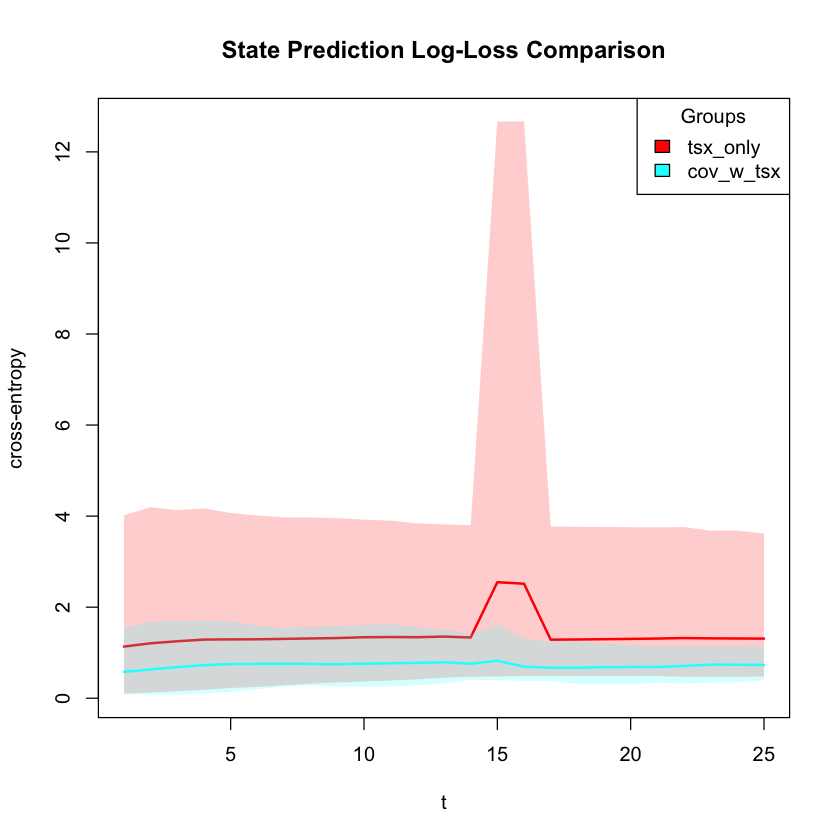

In [504]:
plot_logloss(tsx_only = state_logloss, cov_w_tsx = cov_state_logloss, title = "State Prediction Log-Loss Comparison")

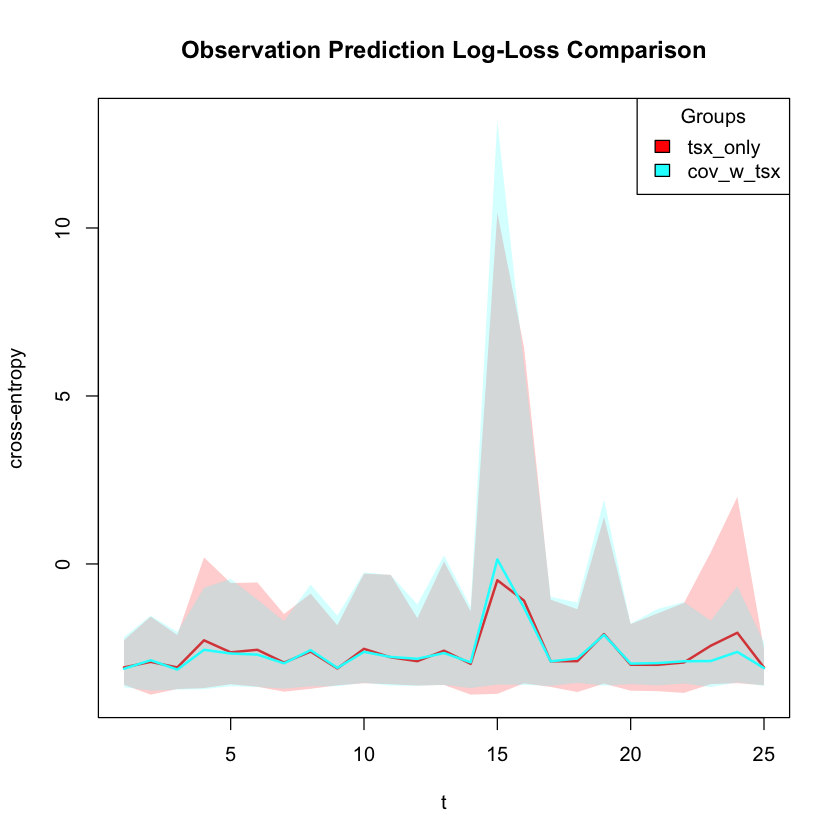

In [505]:
plot_logloss(tsx_only = prediction_logloss, cov_w_tsx = cov_prediction_logloss, title = "Observation Prediction Log-Loss Comparison")